<a href="https://colab.research.google.com/github/Mafaz03/Model/blob/main/MIDaS_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Importing Dependancies

In [ ]:
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import time
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
import os
from pathlib import Path
import requests
import zipfile

In [ ]:
try:
  import timm
except:
  !pip install timm -q
  import timm

In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo -q
  from torchinfo import summary

#2 Setting device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#3 Downloading model

In [ ]:
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS" , model_type)
midas.to(device)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [ ]:
summary(midas)

Layer (type:depth-idx)                             Param #
DPTDepthModel                                      --
├─Module: 1-1                                      --
│    └─VisionTransformer: 2-1                      591,872
│    │    └─PatchEmbed: 3-1                        787,456
│    │    └─Dropout: 3-2                           --
│    │    └─Identity: 3-3                          --
│    │    └─Identity: 3-4                          --
│    │    └─Sequential: 3-5                        302,309,376
│    │    └─LayerNorm: 3-6                         2,048
│    │    └─Identity: 3-7                          --
│    │    └─Dropout: 3-8                           --
│    │    └─Linear: 3-9                            1,025,000
│    └─Sequential: 2-2                             --
│    │    └─ProjectReadout: 3-10                   2,098,176
│    │    └─Transpose: 3-11                        --
│    │    └─Unflatten: 3-12                        --
│    │    └─Conv2d: 3-13                 

#4 Setting transformers

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS" , "transforms")
transforms = midas_transforms.dpt_transform
transforms

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Compose(
    <function transforms.<locals>.<lambda> at 0x7f5110161630>
    <function transforms.<locals>.<lambda> at 0x7f51101616c0>
)

#5 Importing Datasets

In [ ]:
data_path = Path("data/")
image_path = data_path / "random_images"

image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "random_images.zip", "wb") as f:
  request = requests.get("https://github.com/Mafaz03/Datasets/raw/main/Random_images/random_hd_images.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / "random_images.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

os.remove(data_path / "random_images.zip")

In [ ]:
test_image = cv.imread("/content/data/random_images/random_hd_images3.jpg")

In [ ]:
input_transformed = transforms(test_image).to(device)
input_transformed

tensor([[[[ 0.5137,  0.5529,  0.5765,  ...,  0.6157,  0.6314,  0.6314],
          [ 0.5216,  0.4824,  0.5294,  ...,  0.6549,  0.6235,  0.6392],
          [ 0.5373,  0.5373,  0.5686,  ...,  0.6392,  0.6235,  0.6235],
          ...,
          [ 0.5137,  0.5137,  0.5216,  ...,  0.6078,  0.5765,  0.6000],
          [ 0.5137,  0.4824,  0.5765,  ...,  0.6157,  0.6000,  0.6157],
          [ 0.5294,  0.5294,  0.4667,  ...,  0.6078,  0.6314,  0.6078]],

         [[ 0.1608,  0.2000,  0.2078,  ...,  0.3490,  0.3647,  0.3647],
          [ 0.1686,  0.1294,  0.1608,  ...,  0.3804,  0.3490,  0.3647],
          [ 0.1843,  0.1843,  0.2000,  ...,  0.3647,  0.3490,  0.3490],
          ...,
          [ 0.5922,  0.5843,  0.6078,  ...,  0.6627,  0.6314,  0.6549],
          [ 0.5922,  0.5608,  0.6235,  ...,  0.6549,  0.6471,  0.6627],
          [ 0.6078,  0.6000,  0.5529,  ...,  0.6471,  0.6784,  0.6549]],

         [[-0.0039,  0.0353,  0.0431,  ...,  0.2471,  0.2627,  0.2627],
          [ 0.0039, -0.0353, -

#6 Predicting

In [ ]:
with torch.no_grad():
    prediction = midas(input_transformed)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=test_image.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    depth_map = prediction.cpu().numpy()
    depth_map = cv.normalize(depth_map , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
    depth_map_data = cv.normalize(depth_map , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)

    depth_map = (depth_map*255).astype(np.uint8)
    depth_map = cv.applyColorMap(depth_map , cv.COLORMAP_MAGMA)

#7 Visualizing

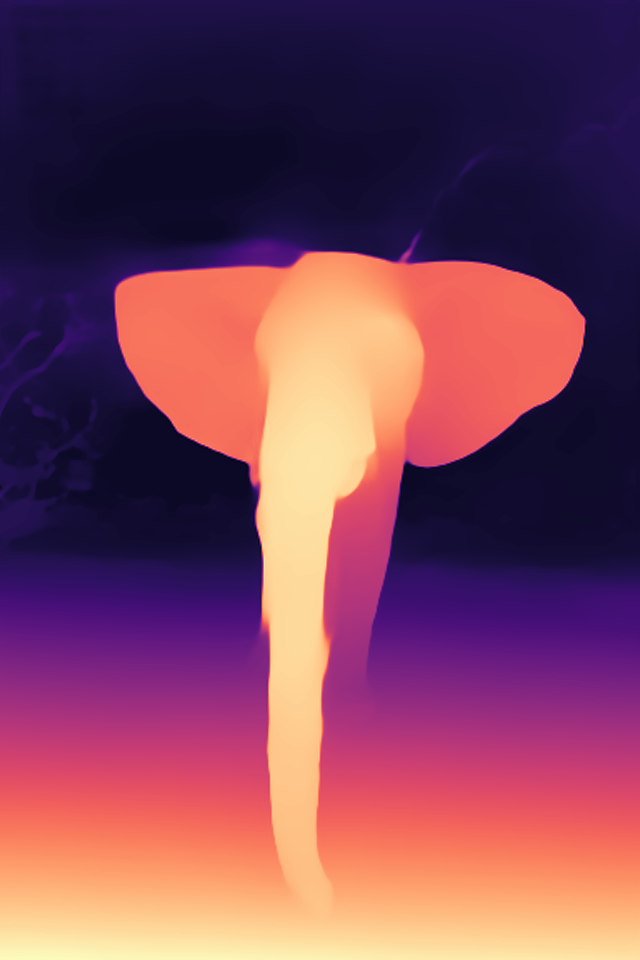

In [ ]:
size=test_image.shape[:2]
test_image_resized = cv.resize(depth_map , (int(size[1]/3) , int(size[0]/3)))
cv2_imshow(test_image_resized)

In [ ]:
depth_map_data

array([[0.1604181 , 0.16032441, 0.15957476, ..., 0.15819522, 0.15927749,
        0.15941275],
       [0.16033441, 0.16024143, 0.15949753, ..., 0.15806483, 0.15913686,
        0.15927083],
       [0.15966473, 0.1595775 , 0.15887957, ..., 0.15702165, 0.15801167,
        0.15813539],
       ...,
       [0.99653491, 0.99654169, 0.99659489, ..., 0.94512104, 0.9450034 ,
        0.94498865],
       [0.99666682, 0.9966739 , 0.99672974, ..., 0.9454088 , 0.94527718,
        0.94526079],
       [0.99668315, 0.99669029, 0.99674642, ..., 0.9454445 , 0.9453113 ,
        0.94529462]])

In [ ]:
depth_map_data.shape

(2880, 1920)